In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_37.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_7.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_30.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_1.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_27.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_22.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_9.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_6.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_3.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_12.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_5.mp4
/kaggle/input/exercice-classification-1/ComputerVisionData/pull Up/pull up_14.mp4
/kaggle/input/exercice

In [2]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google

In [3]:
import cv2
import mediapipe as mp
import os
import numpy as np

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

def extract_keypoints_from_video(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    keypoints_seq = []
    frame_count = 0
    
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame)
        if result.pose_landmarks:
            landmarks = result.pose_landmarks.landmark
            keypoints = []
            for lm in landmarks:
                keypoints.extend([lm.x, lm.y, lm.z])
            keypoints_seq.append(keypoints)
        frame_count += 1
    
    cap.release()
    
    return np.array(keypoints_seq)

2025-05-26 20:49:04.728276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748292544.938358      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748292545.000757      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from glob import glob

data_dir = "/kaggle/input/exercice-classification-1/ComputerVisionData"
exercise_classes = sorted(os.listdir(data_dir))
label_map = {label: idx for idx, label in enumerate(exercise_classes)}

X = []
y = []

for label in exercise_classes:
    video_paths = glob(os.path.join(data_dir, label, "*.mp4"))
    for video_path in video_paths:
        seq = extract_keypoints_from_video(video_path)
        if len(seq) > 0:
            # Pad or truncate to fixed length
            padded_seq = np.zeros((100, 99))  # 33 landmarks * 3 (x,y,z)
            padded_seq[:min(len(seq), 100)] = seq[:100]
            X.append(padded_seq)
            y.append(label_map[label])


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1748292558.913230     101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748292558.986831     102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748292559.064991     103 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf

X = np.array(X)
y = np.array(y)
X = (X - X.mean()) / X.std()  # Normalize

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=5)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking

model = Sequential([
    Masking(mask_value=0.0, input_shape=(100, 99)),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-26 21:01:49.533112: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 100, 99)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │          87,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,517 (377.02 KB)

 Trainable params: 96,517 (377.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=20, batch_size=16)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.3258 - loss: 1.5693 - val_accuracy: 0.5217 - val_loss: 1.1574
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5600 - loss: 1.1963 - val_accuracy: 0.7391 - val_loss: 0.9665
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6715 - loss: 1.0233 - val_accuracy: 0.7391 - val_loss: 0.8754
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7256 - loss: 0.8832 - val_accuracy: 0.7391 - val_loss: 0.7921
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7746 - loss: 0.7533 - val_accuracy: 0.7391 - val_loss: 0.7109
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7676 - loss: 0.7216 - val_accuracy: 0.8043 - val_loss: 0.6477
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8240 - loss: 0.5898 - val_accuracy: 0.8043 - val_loss: 0.5584
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8658 - loss: 0.4477 - val_accuracy: 0.8043 - 

In [8]:
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8320 - loss: 0.5947
Test Accuracy: 0.83


In [9]:
!pip install optuna

In [10]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os


In [11]:
def create_model(trial, input_shape, num_classes):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Sample GRU units
    n_units = trial.suggest_int("n_units", 64, 256, step=32)
    model.add(GRU(n_units, return_sequences=False))

    # Sample dropout rate
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.6)
    model.add(Dropout(dropout_rate))

    # Optional dense layer
    dense_units = trial.suggest_int("dense_units", 32, 128, step=32)
    model.add(Dense(dense_units, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    # Sample learning rate
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def objective(trial):
    model = create_model(trial, input_shape=(100, 99), num_classes=5)

    # You can reduce epochs for faster tuning
    history = model.fit(X_train, y_train_cat, 
                        validation_data=(X_test, y_test_cat),
                        epochs=10, 
                        batch_size=trial.suggest_categorical("batch_size", [8, 16, 32]),
                        verbose=0)

    val_acc = history.history["val_accuracy"][-1]
    return val_acc


In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-05-26 21:02:15,916] A new study created in memory with name: no-name-783726c2-a4a8-4299-8f52-7e2960215e4a
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-05-26 21:02:28,623] Trial 0 finished with value: 0.760869562625885 and parameters: {'n_units': 192, 'dropout': 0.4177791664083874, 'dense_units': 96, 'lr': 0.00010959901499780093, 'batch_size': 32}. Best is trial 0 with value: 0.760869562625885.
[I 2025-05-26 21:02:38,498] Trial 1 finished with value: 0.8478260636329651 and parameters: {'n_units': 64, 'dropout': 0.4349625856514985, 'dense_units': 96, 'lr': 0.00600937669988224, 'batch_size': 16}. Best is trial 1 with value: 0.8478260636329651.
[I 2025-05-26 21:02:48,781] Trial 2 finished with value: 0.6521739363670349 and parameters

In [14]:
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params:", trial.params)

# Rebuild and save best model
best_model = create_model(trial, input_shape=(100, 99), num_classes=5)
best_model.fit(X_train, y_train_cat,
               validation_data=(X_test, y_test_cat),
               epochs=19,
               batch_size=trial.params["batch_size"],
               verbose=1)

best_model.save("best_exercise_classifier.h5")


Best trial:
  Accuracy: 0.8478
  Params: {'n_units': 64, 'dropout': 0.4349625856514985, 'dense_units': 96, 'lr': 0.00600937669988224, 'batch_size': 16}
Epoch 1/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.3141 - loss: 1.5156 - val_accuracy: 0.7174 - val_loss: 1.0270
Epoch 2/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6045 - loss: 1.1256 - val_accuracy: 0.7826 - val_loss: 0.7745
Epoch 3/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5936 - loss: 0.9098 - val_accuracy: 0.8043 - val_loss: 0.6858
Epoch 4/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8106 - loss: 0.6015 - val_accuracy: 0.8261 - val_loss: 0.5446
Epoch 5/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8755 - loss: 0.4179 - val_accuracy: 0.8478 - val_loss: 0.5985
Epoch 6/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9118 - loss: 0.3323 - val_accuracy: 0.7826 - val_loss: 0.5915
Epoch 7/19
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8914 - loss: 0.3464 -

In [17]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/best_exercise_classifier.h5")


In [18]:
pred_probs = model.predict(X_test)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(y_test_cat, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


In [19]:
inv_label_map = {v: k for k, v in label_map.items()}
pred_labels = [inv_label_map[p] for p in pred_classes]
true_labels = [inv_label_map[t] for t in true_classes]


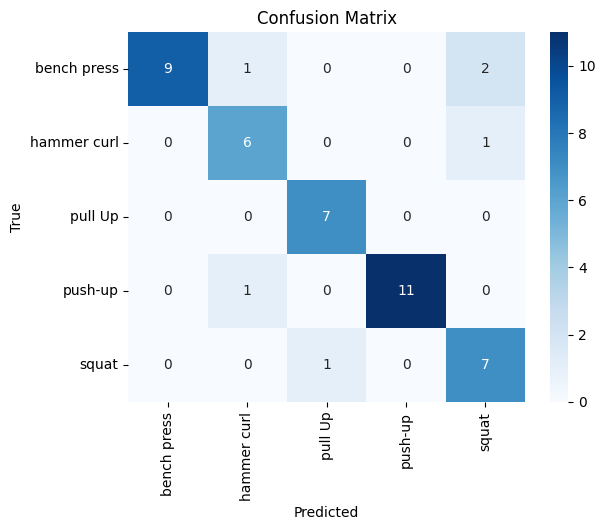

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, labels=exercise_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=exercise_classes, yticklabels=exercise_classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [21]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

 bench press       1.00      0.75      0.86        12
 hammer curl       0.75      0.86      0.80         7
     pull Up       0.88      1.00      0.93         7
     push-up       1.00      0.92      0.96        12
       squat       0.70      0.88      0.78         8

    accuracy                           0.87        46
   macro avg       0.86      0.88      0.86        46
weighted avg       0.89      0.87      0.87        46



In [22]:
new_video_path = "/kaggle/input/exercice-classification-1/ComputerVisionData/push-up/push-up_36.mp4"
sequence = extract_keypoints_from_video(new_video_path)

if len(sequence) > 0:
    padded_seq = np.zeros((100, 99))
    padded_seq[:min(len(sequence), 100)] = sequence[:100]
    padded_seq = (padded_seq - X.mean()) / X.std()  # normalize like training

    pred = model.predict(np.expand_dims(padded_seq, axis=0))
    pred_label = inv_label_map[np.argmax(pred)]
    print("Predicted Exercise:", pred_label)
else:
    print("No pose landmarks detected in the video.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Exercise: push-up
